In [1]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import torch.nn as nn
import pathlib
from functools import partial
import sys, glob, os, copy
import numpy as np
from typing import List, OrderedDict, Union

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/architectures')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

from timm.models.fx_features import GraphExtractNet
import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.utils import intermediate_layer_names
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH, DATA_PATH_FLOWERS_PETS

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
    }
}

In [3]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [13]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[1].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)


def get_layerwise_test_acc(model, source_dataset, finetuning_dataset, 
                           checkpoint_path, base_model_path, append):
    """
    checkpoint_path: base model to load when creating model
    base_model_path: directory with linear probe weights of diff layers
    """
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else \
            DATA_PATH_FLOWERS_PETS if finetuning_dataset in ['flowers','oxford-iiit-pets'] else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset),
                           loading_function_kwargs={'strict': False})
    original_model = copy.deepcopy(m1.model)
    layer_names = intermediate_layer_names(m1.model)
    print (layer_names)
    layer_to_acc = {}
    for layer_name in layer_names[:-1:5]:
        FRACTIONS = glob.glob(f'{base_model_path}/'
                              f'frac-*-mode-random-seed-*-ftmode-linear-lr-0.1-bs-256-{append}/'
                              f'*-{layer_name}-topk=1.ckpt')
        FRACTIONS = sorted(list(set(
            [float(x.split('/frac-')[1].split('-')[0]) for x in FRACTIONS \
             if len(x.split('/frac-')[1].split('-')[0]) == 7]
        )))
        if len(FRACTIONS) == 0:    continue

        frac_to_accs = {}
        for fraction in FRACTIONS:
            model_paths = glob.glob(f'{base_model_path}/'
                                   f'frac-{fraction:.5f}-mode-random-seed-*-ftmode-linear-lr-0.1-bs-256-{append}/'
                                   f'*-{layer_name}-topk=1.ckpt')
            print (f'layer_name: {layer_name}, {len(model_paths)}')
            for model_path in model_paths[:2]:
                cached_preds = load_predictions(model_path)
                if cached_preds is not None:
                    print (f'Loaded cached for {model_path}')
                    acc = accuracy(cached_preds['gt'], cached_preds['pred']).item()
                else:
                    seed = int(model_path.split('seed-')[1].split('-')[0])
                    state_dict = torch.load(model_path)
                    chopped_model = GraphExtractNet(copy.deepcopy(original_model), [layer_name])
                    m1.model = nn.Sequential(
                        OrderedDict([
                            ('feature_extractor', chopped_model), 
                            ('flatten', nn.Flatten(1))
                            ]))
                    new_layer = ft.setup_model_for_finetuning(
                        m1.model,
                        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
                        'random', fraction, seed, 
                        inplace=True, infer_features=True)
                    new_layer.load_state_dict(
                        {'.'.join(k.split('.')[-2:]):v for k, v in state_dict['state_dict'].items()}, 
                                              strict=True)
                    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
                        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
                    pl_utils.seed.seed_everything(seed, workers=True)
                    trainer = Trainer(accelerator='gpu', 
                                      devices=DEVICES,
                                      num_nodes=NUM_NODES,
                                      log_every_n_steps=1,
                                      auto_select_gpus=True, 
                                      deterministic=True,
                                      check_val_every_n_epoch=1,
                                      num_sanity_val_steps=0,
                                      callbacks=[
                                        LitProgressBar(['loss', 
                                                        'running_test_acc'])])
                    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
                    save_predictions(model_path, out)
                    gt, pred = out[1], out[0]
                    acc = accuracy(gt, pred).item()
                
                if fraction in frac_to_accs:
                    frac_to_accs[fraction].append(acc)
                else:
                    frac_to_accs[fraction] = [acc]
        
        layer_to_acc[layer_name] = frac_to_accs

    return layer_to_acc

Global seed set to 2


['layer1.0.act3', 'layer1.1.act3', 'layer1.2.act3', 'layer2.0.act3', 'layer2.1.act3', 'layer2.2.act3', 'layer2.3.act3', 'layer3.0.act3', 'layer3.1.act3', 'layer3.2.act3', 'layer3.3.act3', 'layer3.4.act3', 'layer3.5.act3', 'layer4.0.act3', 'layer4.1.act3', 'layer4.2.act3', 'global_pool.pool']
layer_name: layer1.0.act3, 4
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.00050-mode-random-seed-4-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=27-layer1.0.act3-topk=1.ckpt
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.00050-mode-random-seed-3-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=32-layer1.0.act3-topk=1.ckpt
layer_name: layer1.0.act3, 4
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.00500-mode-random-seed-2-ft

Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.50000-mode-random-seed-3-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=39-layer2.2.act3-topk=1.ckpt
layer_name: layer2.2.act3, 4
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.80000-mode-random-seed-3-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=39-layer2.2.act3-topk=1.ckpt


Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 4
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.90000-mode-random-seed-2-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=28-layer2.2.act3-topk=1.ckpt
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.90000-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=46-layer2.2.act3-topk=1.ckpt
layer_name: layer2.2.act3, 1
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-1.00000-mode-random-seed-2-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=36-layer2.2.act3-topk=1.ckpt
layer_name: layer3.3.act3, 4
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.00050-mode-random-seed-4-ftmode-linear-lr-0.1-bs-256

Global seed set to 2


Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.50000-mode-random-seed-3-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=29-layer4.2.act3-topk=1.ckpt
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.50000-mode-random-seed-2-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=42-layer4.2.act3-topk=1.ckpt
layer_name: layer4.2.act3, 4
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.80000-mode-random-seed-3-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=16-layer4.2.act3-topk=1.ckpt
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar10/frac-0.80000-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=34-layer4.2.act3-topk=1.ckpt
layer_name: lay

layer_name: layer3.3.act3, 2
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.00050-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=34-layer3.3.act3-topk=1.ckpt
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.00050-mode-random-seed-2-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=45-layer3.3.act3-topk=1.ckpt
layer_name: layer3.3.act3, 2
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.00500-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=47-layer3.3.act3-topk=1.ckpt
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.00500-mode-random-seed-2-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=45-layer3.3

Global seed set to 2


layer_name: layer4.2.act3, 1
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.00050-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=24-layer4.2.act3-topk=1.ckpt
layer_name: layer4.2.act3, 1
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.00500-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=30-layer4.2.act3-topk=1.ckpt
layer_name: layer4.2.act3, 1
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.05000-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=25-layer4.2.act3-topk=1.ckpt
layer_name: layer4.2.act3, 1
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-cifar100/frac-0.10000-mode-random-s

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 3


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 3


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2


['layer1.0.act3', 'layer1.1.act3', 'layer1.2.act3', 'layer2.0.act3', 'layer2.1.act3', 'layer2.2.act3', 'layer2.3.act3', 'layer3.0.act3', 'layer3.1.act3', 'layer3.2.act3', 'layer3.3.act3', 'layer3.4.act3', 'layer3.5.act3', 'layer4.0.act3', 'layer4.1.act3', 'layer4.2.act3', 'global_pool.pool']
layer_name: layer1.0.act3, 5
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-oxford-iiit-pets/frac-0.00050-mode-random-seed-1-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=40-layer1.0.act3-topk=1.ckpt
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-oxford-iiit-pets/frac-0.00050-mode-random-seed-5-ftmode-linear-lr-0.1-bs-256-nonrob/epoch=33-layer1.0.act3-topk=1.ckpt
layer_name: layer1.0.act3, 5
Loaded cached for /NS/robustness_2/work/vnanda/invariances_in_reps/partially_inverted_reps/checkpoints/resnet50-base-imagenet-ft-oxford-iiit-pets/frac-0.

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 3


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 2


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

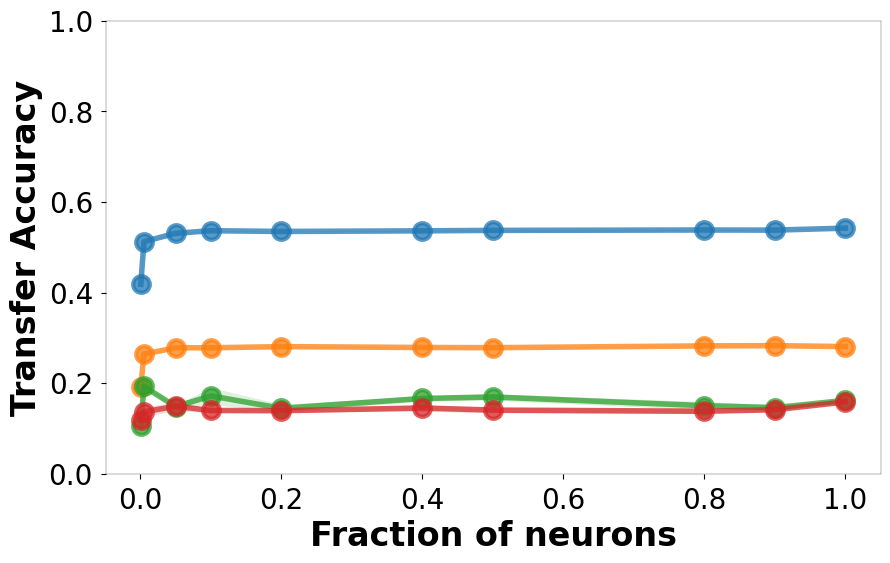

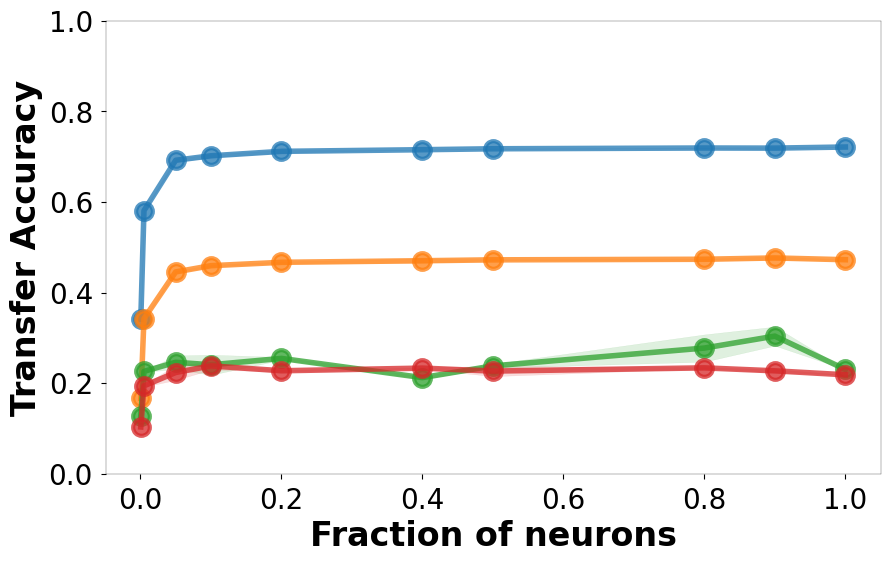

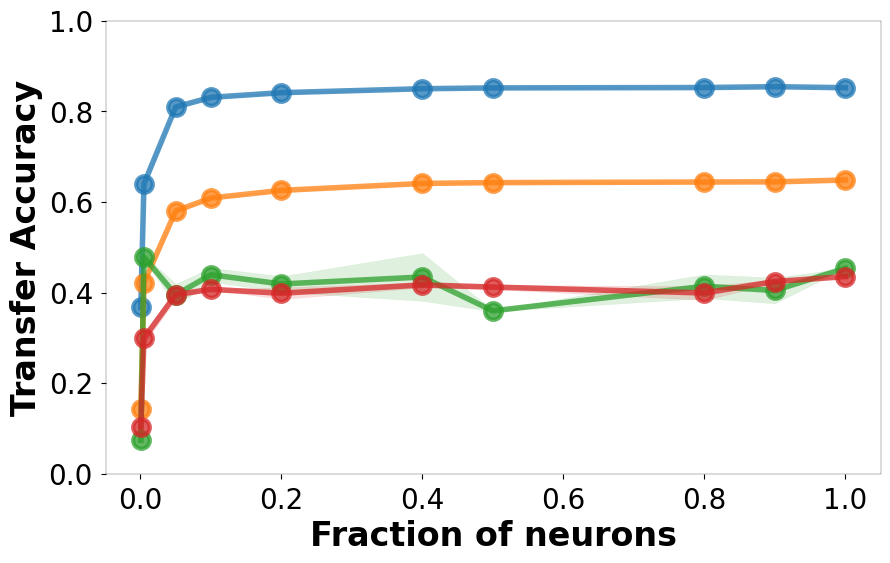

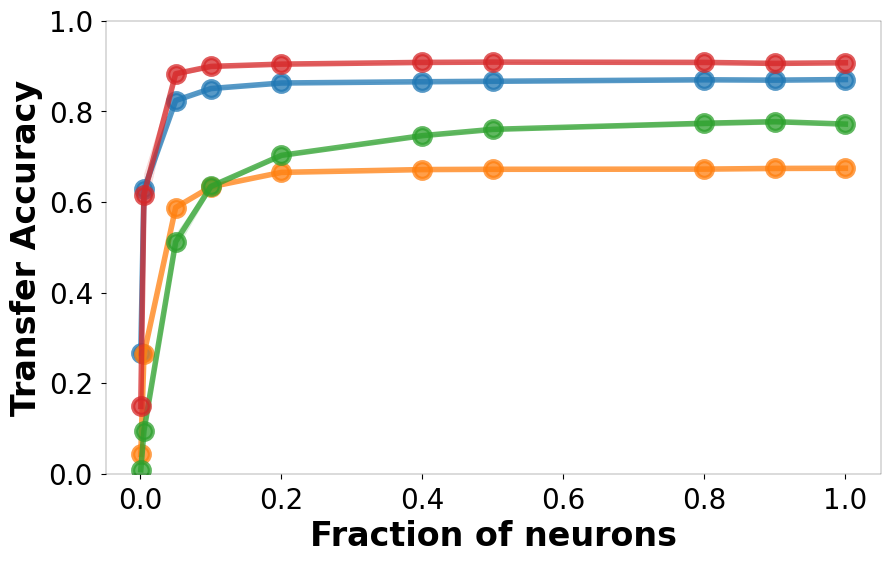

Global seed set to 2


['layer1.0.act3', 'layer1.1.act3', 'layer1.2.act3', 'layer2.0.act3', 'layer2.1.act3', 'layer2.2.act3', 'layer2.3.act3', 'layer3.0.act3', 'layer3.1.act3', 'layer3.2.act3', 'layer3.3.act3', 'layer3.4.act3', 'layer3.5.act3', 'layer4.0.act3', 'layer4.1.act3', 'layer4.2.act3', 'global_pool.pool']
layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer2.2.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer3.3.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 4
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 4


Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

layer_name: layer4.2.act3, 1


Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

Global seed set to 2
Global seed set to 2


['layer1.0.act3', 'layer1.1.act3', 'layer1.2.act3', 'layer2.0.act3', 'layer2.1.act3', 'layer2.2.act3', 'layer2.3.act3', 'layer3.0.act3', 'layer3.1.act3', 'layer3.2.act3', 'layer3.3.act3', 'layer3.4.act3', 'layer3.5.act3', 'layer4.0.act3', 'layer4.1.act3', 'layer4.2.act3', 'global_pool.pool']


Global seed set to 2


['layer1.0.act3', 'layer1.1.act3', 'layer1.2.act3', 'layer2.0.act3', 'layer2.1.act3', 'layer2.2.act3', 'layer2.3.act3', 'layer3.0.act3', 'layer3.1.act3', 'layer3.2.act3', 'layer3.3.act3', 'layer3.4.act3', 'layer3.5.act3', 'layer4.0.act3', 'layer4.1.act3', 'layer4.2.act3', 'global_pool.pool']
['layer1.0.act3', 'layer1.1.act3', 'layer1.2.act3', 'layer2.0.act3', 'layer2.1.act3', 'layer2.2.act3', 'layer2.3.act3', 'layer3.0.act3', 'layer3.1.act3', 'layer3.2.act3', 'layer3.3.act3', 'layer3.4.act3', 'layer3.5.act3', 'layer4.0.act3', 'layer4.1.act3', 'layer4.2.act3', 'global_pool.pool']


IndexError: list index out of range

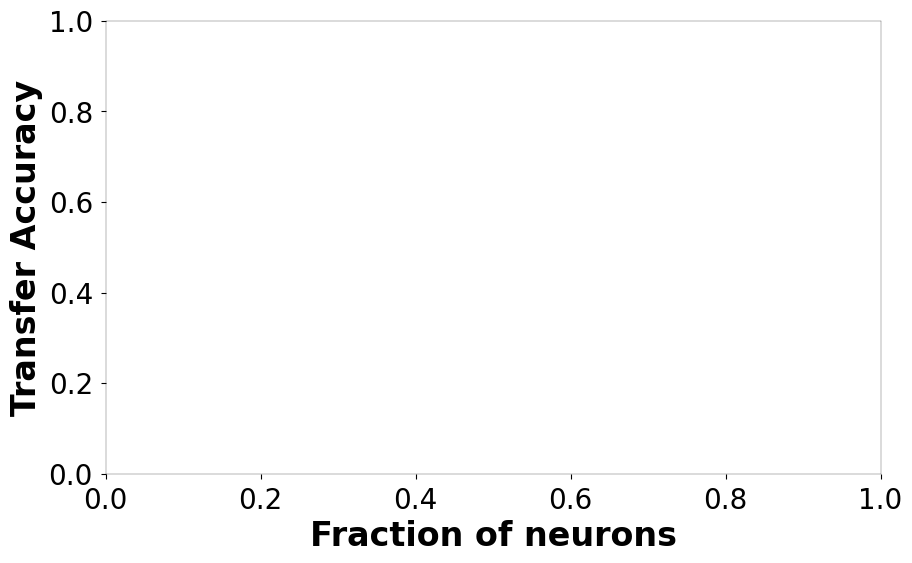

In [14]:
SOURCE_DATASETS = ['imagenet']
MODELS = CHECKPOINT_PATHS.keys()

for model in MODELS:
    for append in CHECKPOINT_PATHS[model].keys():
        checkpoint_path = CHECKPOINT_PATHS[model][append]
        for source_dataset in SOURCE_DATASETS:
            all_res = {}
            for finetuning_dataset in FINETUNING_DATASETS:
                base_model_path = f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{finetuning_dataset}'
                layer_to_acc = get_layerwise_test_acc(model, source_dataset, finetuning_dataset, 
                                       checkpoint_path, base_model_path, append)
            
                for layer in layer_to_acc.keys():
                    if layer not in all_res:
                        all_res[layer] = {ft_ds:{} for ft_ds in FINETUNING_DATASETS}
                    all_res[layer][finetuning_dataset] = layer_to_acc[layer]
            
            for layer in all_res.keys():
                plt_hp.line_plot(
                    [[np.nanmean(all_res[layer][ft_ds][f]) \
                      for f in sorted(all_res[layer][ft_ds].keys())] \
                     for ft_ds in FINETUNING_DATASETS], 
                    'Fraction of neurons', 'Transfer Accuracy', layer, subfolder=layer, 
                    filename=f'{model}_base_{source_dataset}_{append}', 
                    extension='png', x_vals=[[f for f in sorted(all_res[layer][ft_ds].keys())] \
                                             for ft_ds in FINETUNING_DATASETS], 
                    legend_vals=FINETUNING_DATASETS, vertical_line=None, colors=plt_hp.COLORS, 
                    linestyles=['-'] * len(FINETUNING_DATASETS), 
                    y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
                    plot_inside=False, legend_location='best', savefig=True, 
                    figsize=(10,6), marker=[True] * len(FINETUNING_DATASETS), 
                    results_subfolder_name='middle_layer_analysis', grid_spacing=None, 
                    y_err=[[np.nanstd(all_res[layer][ft_ds][f]) \
                            for f in sorted(all_res[layer][ft_ds].keys())] \
                           for ft_ds in FINETUNING_DATASETS], 
                    legend_ncol=4)